<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Entrenamiento_reconocimiento_acordes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset de Kaggle](https://www.kaggle.com/datasets/fabianavinci/guitar-chords-v3/data)

Instalar las librerías necesarias, que no están en el entorno de google colab

In [1]:
!pip install tensorflow-io==0.25.0
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0
    Uninstalling tensorflow-io-gcs-filesystem-0.37.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.0


Importar las librerías que voy a utilizar

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
#import tensorflow_io as tfio

import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from google.colab import drive

import librosa
import librosa.display

import cv2
import random
import imgaug as ia # librería para realizar transformaciones a las imágenes y poder generar aumento de los datos
import imgaug.augmenters as iaa
import albumentations as A
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torchvision.transforms import GaussianBlur


Monto mi unidad de Google Drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Establezco los directorios de partida

In [4]:
DATASET_audios = '/content/drive/MyDrive/proyecto deteccion acordes/dataset audios'
dir_datos = pathlib.Path(DATASET_audios)
dir_train = pathlib.Path(f'{DATASET_audios}/Training')
dir_test  = pathlib.Path(f'{DATASET_audios}/Test')

Creo un array con los acordes de los que tengo acceso a audios

In [5]:
acordes = np.array(tf.io.gfile.listdir(str(dir_train)))
print('Acordes :', acordes)

Acordes : ['Am' 'Bb' 'C' 'Dm' 'Bdim' 'G' 'F' 'Em']


Resumen de muestras para entrenamiento y por cada tipo de acorde

In [6]:
filenames = tf.io.gfile.glob(str(dir_train) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Muestras para entrenamiento:', num_samples)
print('Muestras por acorde        : ',
      len(tf.io.gfile.listdir(str(dir_train/acordes[0]))))


Muestras para entrenamiento: 1442
Muestras por acorde        :  180


Resumen de los datos por conjunto

In [7]:
train_files = filenames[:1152]
val_files = filenames[-288:]
test_files = tf.io.gfile.glob(str(dir_test) + '/*/*')

print('Tamaño de los datos de Entrenamiento : ', len(train_files))
print('Tamaño de los datos de Validación    :  ', len(val_files))
print('Tamaño de los datos de Test          :  ', len(test_files))

Tamaño de los datos de Entrenamiento :  1152
Tamaño de los datos de Validación    :   288
Tamaño de los datos de Test          :   320


**Extraigo de cada muestra, el segundo más representativo y lo guardo como una imagen.**

El segundo más representativo es aquel en el que la intendidad de sonido media(volumen medio) es más alta. Es el segundo que nos dará más información, por cada muestra y es una manera de acotar y normalizarlas.

Deshabilito la representación en pantalla, para no eternizar la ejecución de las cargas de los datasets.

In [8]:
def decode_audio(audio, dir_salida):
  #separo la ruta del nombre de la imagen
  directorio, fichero = os.path.split(audio)
  nombre, extension=os.path.splitext(fichero)

  nombreimagen = os.path.join(directorio,f"{nombre}.png")

  #Extraigo, con Librosa, la información del fichero de sonido
  audio_data, sample_rate = librosa.load(audio)

  #separar la parte armónica de la percusiva del audio de origen
  audio_harmonic, audio_percussive = librosa.effects.hpss(audio_data)

  # Calcular la duración del audio
  duration = len(audio_data) / sample_rate

  # Encontrar la sección más representativa de 1/2 segundo
  #start_time = duration / 2 - 0.5  # Empieza 0.5 segundos antes del punto medio
  #end_time = start_time + 1.0
  start_time = duration / 2 - 0.25  # Empieza 0.25 segundos antes del punto medio
  end_time = start_time + 0.5
  start_frame = int(start_time * sample_rate)
  end_frame = int(end_time * sample_rate)
  audio_segment = audio_data[start_frame:end_frame]

  # Deshabilitar la visualización interactiva de las imágenes
  plt.ioff()

  # Generar la espectrografía de la sección más representativa
  plt.figure(figsize=(4, 4), frameon=False)
  librosa.display.specshow(librosa.power_to_db(abs(librosa.stft(audio_harmonic)), ref=np.max), y_axis='log', x_axis='time', cmap='viridis')
  plt.axis('off')
  plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

  # Guardar la imagen
  nombreimagen = os.path.join(dir_salida, f"{nombre}.png")
  plt.savefig(nombreimagen, bbox_inches='tight', pad_inches=0)

  # Volver a habilitar la visualización interactiva de las imágenes
  plt.ion()

Cargo cada dataset con las imágenes resultantes de cada audio

In [9]:
def load_dataset(dirname):
 X = []
 y = []
 entorno =os.path.basename(os.path.dirname(dirname))
 for indice,acorde  in enumerate(acordes):
  files = os.listdir(os.path.join(dirname, acorde))
  images = [file for file in files if file.lower().endswith("png")]
  print("Leyendo {} imágenes de {} encontradas de {}".format(len(images), entorno,acorde))
  i=0
  for image_name in images:
    i+=1
    print(' cargando {} de {} imágenes'.format(i,len(images)))
    imagen = cv2.imread(os.path.join(dirname, acorde, image_name))
    imagen = cv2.resize(imagen, (300,300), interpolation=cv2.INTER_CUBIC)

    X.append(imagen)
    y.append(indice)

 return np.array(X), np.array(y)

Rellenar el directorio de imágenes, separados por Entrenamiento y Test y por cada acorde (clase)

In [10]:
def cargar_dir_imagenes(entorno, dir_salida):
  dir_entrada =os.path.join(DATASET_audios,entorno)
  for acorde in acordes:
    files =os.listdir(os.path.join(dir_entrada, acorde))
    audios = [file for file in files if file.lower().endswith("wav")]
    print("leyendo {} audios de {} encontrados de ".format(len(audios), entorno), acorde)
    for audio in audios:
      audio = os.path.join(dir_entrada,acorde, audio)
      dir_salida_nota= os.path.join(dir_salida, acorde)
      decode_audio(audio, dir_salida_nota)

Creo los directorios de train y de test en mi carpeta de google colab

In [11]:
ruta_raiz  = '/content/imagenes'
ruta_train = ruta_raiz + '/train/'
ruta_test  = ruta_raiz + '/test/'
os.makedirs(ruta_raiz)
os.makedirs(ruta_train)
os.makedirs(ruta_test)

Creo una carpeta por cada acorde

In [12]:
for clase in acordes:
  os.makedirs(ruta_train + clase)
  os.makedirs(ruta_test + clase)

Data Augmentation

In [14]:
def aumentar_datos(dirname):
  augmentations = iaa.Sequential([
  #iaa.Fliplr(0.5), # Volteo horizontal con probabilidad 50%
  iaa.GaussianBlur(sigma=(0.0, 1.0)), # Añadir desenfoque gaussiano aleatorio
  iaa.Add((-10, 10), per_channel=0.5), # Añadir brillo aleatorio
  iaa.Multiply((0.8, 1.2), per_channel=0.5)]) # Ajustar contraste aleatorio
  for acorde in acordes:
    files = os.listdir(os.path.join(dirname, acorde))
    images = [file for file in files if file.lower().endswith("png") ]
    for image_name in images:
      imagen = cv2.imread(os.path.join(dirname, acorde, image_name))
      # Aplicar las transformaciones a la imagen, si es el dataset de train
      augmented_image = augmentations(image=imagen)
      # Guardar la imagen aumentada
      imagen_pil_aumentada= Image.fromarray(augmented_image)
      imagen_pil_aumentada.save(os.path.join( dirname,acorde,"aum_" + image_name))
      # añadir ruido de 3x3
      imagen_blur = cv2.blur(imagen, (3, 3))
      cv2.imwrite(os.path.join( dirname,acorde,"blur_" + image_name),imagen_blur)

Normalización de las imágenes.

In [13]:
def normalizar_imagenes(dirname):
  for acorde in acordes:
    files = os.listdir(os.path.join(dirname, acorde))
    images = [file for file in files if file.lower().endswith("png")]
    for image_name in images:
      imagen = cv2.imread(os.path.join(dirname, acorde, image_name))
      # Convierto todas las imágenes a escala de grises
      imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Normalio todas las imágenes a escala de grises
      imagen_gris = Image.fromarray(imagen_gris)
      imagen_gris.save(os.path.join( dirname,acorde, image_name))

In [14]:
cargar_dir_imagenes ('Test',ruta_test)
cargar_dir_imagenes ('Training',ruta_train)

leyendo 40 audios de Test encontrados de  Am


<ipython-input-8-49b59ef4afd4>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4), frameon=False)


leyendo 40 audios de Test encontrados de  Bb
leyendo 40 audios de Test encontrados de  C
leyendo 40 audios de Test encontrados de  Dm
leyendo 40 audios de Test encontrados de  Bdim
leyendo 40 audios de Test encontrados de  G
leyendo 40 audios de Test encontrados de  F
leyendo 40 audios de Test encontrados de  Em
leyendo 180 audios de Training encontrados de  Am
leyendo 180 audios de Training encontrados de  Bb
leyendo 180 audios de Training encontrados de  C
leyendo 180 audios de Training encontrados de  Dm
leyendo 180 audios de Training encontrados de  Bdim
leyendo 180 audios de Training encontrados de  G
leyendo 180 audios de Training encontrados de  F
leyendo 180 audios de Training encontrados de  Em


In [15]:
normalizar_imagenes(ruta_train)
normalizar_imagenes(ruta_test)

In [16]:
X_t, y_t = load_dataset(ruta_train)
X_test, y_test = load_dataset(ruta_test)

Leyendo 180 imágenes de train encontradas de Am
 cargando 1 de 180 imágenes
 cargando 2 de 180 imágenes
 cargando 3 de 180 imágenes
 cargando 4 de 180 imágenes
 cargando 5 de 180 imágenes
 cargando 6 de 180 imágenes
 cargando 7 de 180 imágenes
 cargando 8 de 180 imágenes
 cargando 9 de 180 imágenes
 cargando 10 de 180 imágenes
 cargando 11 de 180 imágenes
 cargando 12 de 180 imágenes
 cargando 13 de 180 imágenes
 cargando 14 de 180 imágenes
 cargando 15 de 180 imágenes
 cargando 16 de 180 imágenes
 cargando 17 de 180 imágenes
 cargando 18 de 180 imágenes
 cargando 19 de 180 imágenes
 cargando 20 de 180 imágenes
 cargando 21 de 180 imágenes
 cargando 22 de 180 imágenes
 cargando 23 de 180 imágenes
 cargando 24 de 180 imágenes
 cargando 25 de 180 imágenes
 cargando 26 de 180 imágenes
 cargando 27 de 180 imágenes
 cargando 28 de 180 imágenes
 cargando 29 de 180 imágenes
 cargando 30 de 180 imágenes
 cargando 31 de 180 imágenes
 cargando 32 de 180 imágenes
 cargando 33 de 180 imágenes
 car

Vamos a "barajar" aleatoriamente los datos. Esto es importante ya que, de no hacerlo, estaremos utilizando un pequeño número de piezas para test, que puede que sean del mismo tipo, ya que las imágenes se leen secuencialmente, según el acorde.

In [17]:
perm = np.random.permutation(len(X_t))
X, y = X_t[perm], y_t[perm]

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

Metodo para visualizar una imagen suelta

In [19]:
def visualizar_ejemplo(elemento):
  plt.figure()
  plt.imshow(elemento)
  plt.grid(False)
  plt.show()

Convierte los vectores a matrices categóricas de keras, con 8 clases

In [20]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=8)
y_val_cat   = keras.utils.to_categorical(y_val, num_classes=8)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes=8)

In [21]:
X.shape

(1440, 300, 300, 3)

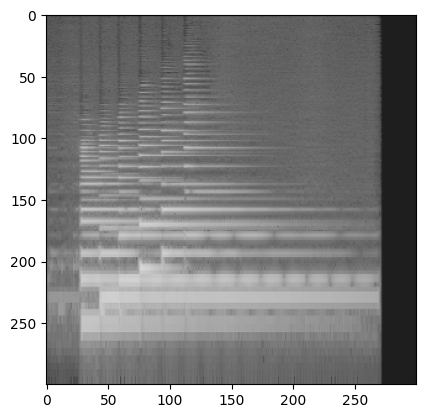

Am
(300, 300, 3)


In [23]:
elemento =20
visualizar_ejemplo(X[elemento]) # Visualiza la imagen
print(acordes[np.argmax(y[elemento])]) #Muestra la clase de figura del elemento
print(X[elemento].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

**Método de entrenamiento del modelo**

Parámetros de entrada *Activación | Épocas | Optimizador | Loss |X de Train | y de train | X de validación | y de validación*

In [24]:
def entrenar_modelo(activa, epocas, optimizador, loss,X, y, X_val, y_val):
  model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(300,300,3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(512, kernel_size=(3, 3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(500, activation=activa),#,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(8, activation='softmax')
  ])

  model.summary()
  model.compile(optimizer=optimizador, loss=loss, metrics=['accuracy'])

  history=model.fit(X,y,  epochs=epocas, validation_split=0.2, validation_data=(X_val, y_val))

  return history, model

In [25]:
history, model=entrenar_modelo('relu',20,'rmsprop','categorical_crossentropy',X_train, y_train_cat, X_val, y_val_cat)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 512)       0

**Análisis visual del aprendizaje de la red**

In [26]:
def plot_acc(history, title="Accuracy del modelo"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Loss del modelo"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

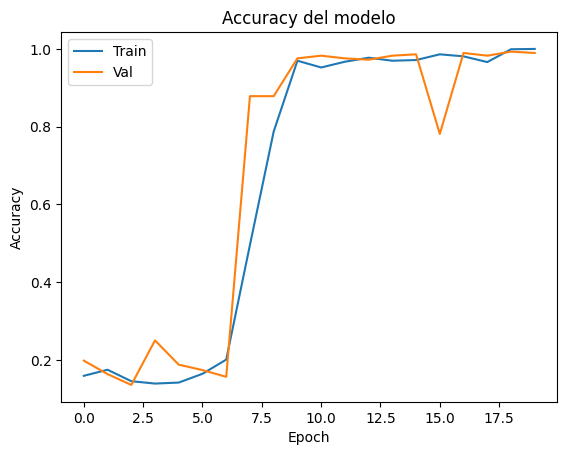

In [27]:
plot_acc(history)

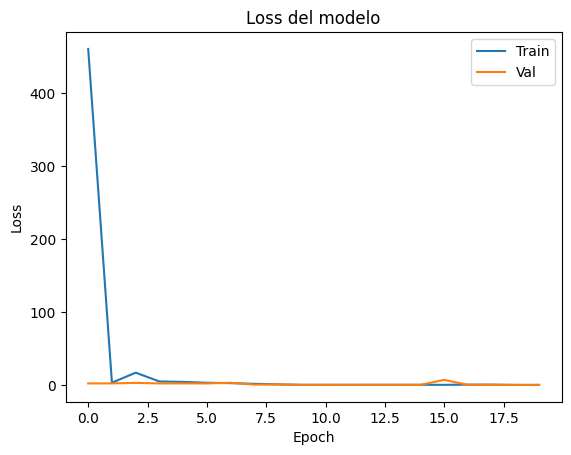

In [28]:
plot_loss(history)

**Evaluación con los datos de test de este modelo**
Da un 95% de precisión


In [30]:
X_tf =tf.convert_to_tensor(X_test,dtype=tf.float32)
model.evaluate(X_tf, y_test_cat, batch_size=32, verbose=1)

10/10 [==============================] - 1s 57ms/step - loss: 0.6104 - accuracy: 0.9750


[0.6103883981704712, 0.9750000238418579]

Guardo todas las predicciones del conjunto de datos de Test

In [31]:
prediccion=model.predict(X_tf)  # Almacenamos todas las predicciones para los datos de test

10/10 [==============================] - 1s 50ms/step


[1.0000000e+00 5.4188555e-29 6.9488612e-26 1.7523810e-20 5.6112353e-20
 1.9200098e-19 1.3439385e-23 2.3910389e-28]
0
Predicción:  Am
Acorde real: Am


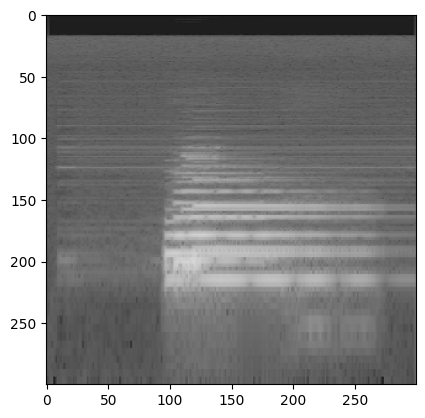

In [33]:
elemento = 36
print(prediccion[elemento]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[elemento])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 8 clases.
print(predicho)
print('Predicción: ',acordes[predicho]) # Acceso al diccionario para mostrar el nombre del acorde predicho.
print('Acorde real:',acordes[y_test[elemento]])
visualizar_ejemplo(X_t[elemento])


**Informe de clasificación**

In [34]:
informe = classification_report(np.argmax(y_test_cat,axis=1), np.argmax(prediccion,axis=1),target_names=acordes, zero_division=0)
print(informe)

              precision    recall  f1-score   support

          Am       1.00      0.90      0.95        40
          Bb       1.00      1.00      1.00        40
           C       1.00      1.00      1.00        40
          Dm       0.95      1.00      0.98        40
        Bdim       0.95      1.00      0.98        40
           G       1.00      1.00      1.00        40
           F       1.00      0.95      0.97        40
          Em       0.90      0.95      0.93        40

    accuracy                           0.97       320
   macro avg       0.98      0.97      0.97       320
weighted avg       0.98      0.97      0.97       320



Guardar modelo entrenado, con sus pesos

In [35]:
model.save('recon_acordes.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


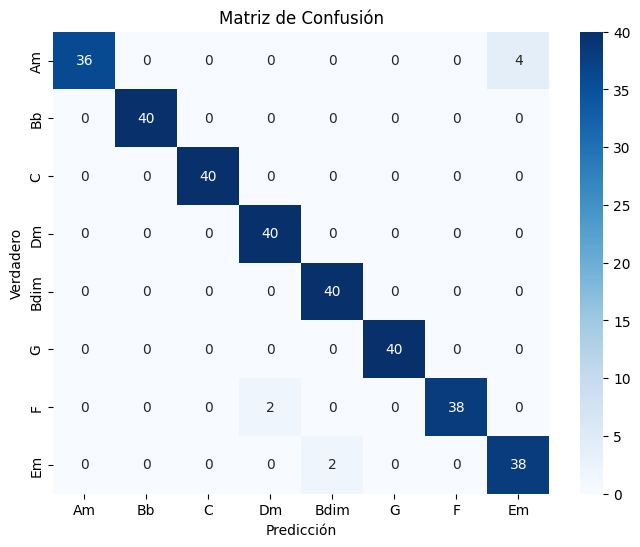

In [43]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, np.argmax(prediccion,axis=1))

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=acordes, yticklabels=acordes)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()
